In [384]:
import docplex.mp.model as md
from docplex.mp.conflict_refiner import ConflictRefiner
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.patches as pch
import matplotlib.pyplot as plt

# 带相序优化的多路径的长干道绿波协调控制模型

# 加载数据

In [385]:
phase = np.loadtxt("phase")
cir=phase[0].sum()
phase=phase/cir
vol = np.loadtxt("volume")
qv = np.loadtxt("path_vol")
phase_get = np.load("phase_get.npy")
d = np.loadtxt("distance")
# dr = np.loadtxt("dr")
# dr=dr/cir
straight_get = np.load("straight_get.npy")

srl_get=np.load("srl_get.npy")
ison = np.array([0, 0, 0, 1, 1, 1])
px = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [386]:
def get_grf(x,phase,idx,k,numr):
    f=sum([x[l,idx,k]*phase[k,l] for l in range(numr) if l!=idx])
    return f

# 常量定义

- $\Delta r_{i,k}$ ：路径i在交叉口k获得的相位与标准相位之间的相位差
- $r_{i,k}$:路径i在交叉口k所获得相位的红灯时间
- $\epsilon$:极小正数
- $q_i$:路径$i$的交通流量
- $Q_k$:交叉口$k$的交通流量
- $d_k(\bar{d}_k)$:交叉口$k$与交叉口$k+1$之间的路段长度
- $f_k(\bar{f}_k)$:交叉口$k$处的上行（下行）方向的速度上限
- $e_k(\bar{e}_k)$:交叉口$k$处的上行（下行）方向的速度下限
- $h_k(\bar{h}_k)$:交叉口$k$处的上行（下行）方向的速度变化下限
- $g_k(\bar{g}_k)$:交叉口$k$处的上行（下行）方向的速度上限

### 基础数据

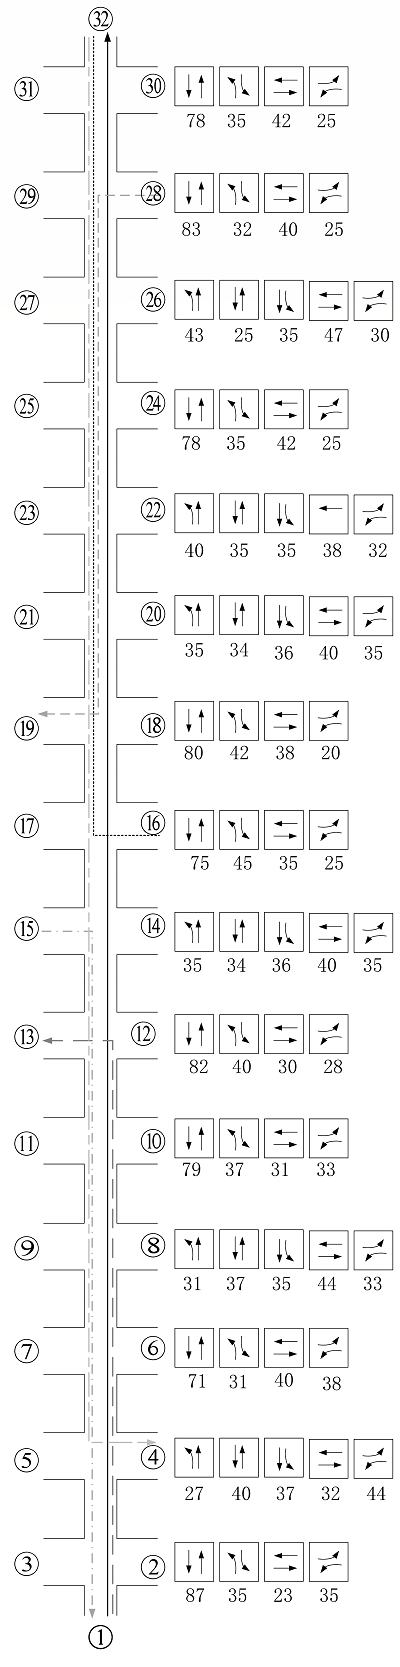

- path 1 ：$1\to 32$  187 $~~~~$交叉口1至交叉口15直行
- path 2 ：$1\to 13$  347 $~~~~$交叉口1至交叉口6左转
- path 3 ：$16\to 32$  285 $~~~~$交叉口8（右转）至交叉口15直行
- path 4 ：$32\to 4$  102 $~~~~$交叉口15至交叉口2左转
- path 5 ：$28\to 19$  114 $~~~~$交叉口14（左转）至交叉口9左转
- path 6 ：$15\to 1$  403 $~~~~$交叉口7（右转）至交叉口1直行

## 速度数据

In [387]:
lower, upper = 8, 12
linspace = np.arange(lower, upper, 1)
lin_num = len(linspace)

# # 南北直行方向绿灯时间
sg=np.array([(straight_get[i]*phase).sum(axis=1) for i in range(len(straight_get))])
# srf=np.array([get_rf(phase,straight_get[i]) for i in range(len(srl_get))])

## 长干道数据

In [388]:
rho = vol[0] / vol[1]
num = len(vol[0])
numr = len(qv)
nump = len(phase_get)
M = 1e6
nx = 0.00000001
be = 8
speedScope = np.array([lower, upper])
speedVar = np.array([-2, 2])

# 变量定义

### 通用变量

In [389]:
model = md.Model("prosmodel")
Z_list = [(i) for i in range(num)]
z = model.continuous_var_dict(Z_list, lb=1 / 200, ub=1 / 80, name="z")

o_list = [(i) for i in range(num)]
o = model.continuous_var_dict(o_list, lb=0, ub=1, name="o")

t_list = [(i, k) for i in range(2) for k in range(num-1)]
t = model.continuous_var_dict(t_list, lb=0, name="t")

$i\in \Omega_i$,  $\Omega_i$表示路径经过的交叉口集合
- $b_{i,k}$:路径$i$在交叉口$k$获得的带宽
- $w_{i,k}$:路径$i$在交叉口$k$的绿波带中心至绿灯相位左侧边缘（秒）
- $p_k$:二进制变量，用于表示交叉口是否为分割点；
$$
p_k=\left\{ \begin{array}{cl}
1,& \text{如果交叉口$k$为干道分割点}\\
0,& \text{其他}
\end{array}\right.
$$
- $\tau_{i,k}$:路径$i$在交叉口$k$的绿波带中心偏移量（秒）
- $\theta_k$:交叉口$k$的绝对相位差
- $t_{k}$:交叉口$k$与交叉口$k+1$之间的行程时间
- $n_{i,k}$:周期的整数倍
- $y_{i,k}$:路径i在交叉口是否能够取得有效带宽


### 长干道变量

In [390]:
p_list = [(i) for i in range(num)]
p = model.binary_var_dict(p_list, name="p")

w_list = [(i, k) for i in range(numr) for k in range(num)]
w = model.continuous_var_dict(w_list, lb=0, ub=1, name="w")

b_list = [(i, k) for i in range(numr) for k in range(num)]
b = model.continuous_var_dict(b_list, lb=0, ub=1, name="b")

n_list = [(i, k) for i in range(numr) for k in range(num)]
n = model.integer_var_dict(n_list, lb=0, ub=10, name="n")

u_list = [(i, k) for i in range(numr) for k in range(num)]
u = model.continuous_var_dict(u_list, lb=0, ub=1, name="u")

y_list = [(i, k) for i in range(numr) for k in range(num)]
y = model.binary_var_dict(y_list, name="y")

x_list = [(l, m, k) for l in range(numr) for m in range(numr) for k in range(num)]
x = model.binary_var_dict(x_list, name="x")

r_list = [(i, k) for i in range(numr) for k in range(num)]
r = model.continuous_var_dict(r_list, lb=0, ub=1, name="r")
rb_list = [(i, k) for i in range(numr) for k in range(num)]
rb = model.continuous_var_dict(rb_list, lb=0, ub=1, name="rb")

# 基于路径的MULTIBAND模型
<strong>基于路径的带宽优化</strong>：将路径作为优化对象，在同一模型里寻找每一条路径的绿波带宽

## 添加约束

### 绿波带宽约束

保障路径$i$的绿波带宽出现出现在交叉口$k$内：
$$
\begin{cases}
b_{i,k}/2\leq w_{i,k}\leq 1-r_{i,k}-b_{i,k}/2\\
\bar{b}_{i,k}/2\leq \bar{w}_{i,k}\leq 1-r_{i,k}-\bar{b}_{i,k}/2
\end{cases}
$$

### 循环整形约束

保障路径$i$的带宽在交叉口$k$与$k+1$的绿波协调:
$$
\begin{cases}
\theta_k+r_{i,k}+\Delta r_{i,k}+w_{i,k}+t_{k}=\theta_{k+1}+r_{i,k+1}+\Delta r_{i,k+1}+w_{i,k+1}+n_{i,k+1}\\
\theta_k+\bar{r}_{i,k}+\Delta \bar{r}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}=\theta_{k+1}+\bar{r}_{i,k+1}+\Delta \bar{r}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}
\end{cases}
$$

### 行程时间约束

行程时间满足约束与multiband类似：
$$
\begin{cases}
\frac{d_k}{f_k}Z_k\leq t_k\leq \frac{d_k}{e_k}Z_k\\
\frac{\bar{d}_k}{\bar{f}_k}Z_k\leq \bar{t}_k\leq\frac{\bar{d}_k}{\bar{e}_k}Z_k
\end{cases}
$$

In [391]:
for k in range(num-1):
    model.add_constraint(d[k] /speedScope[1] * z[k] <= t[0, k])
    model.add_constraint(t[0, k] <= d[k]/ speedScope[0] * z[k])

    model.add_constraint(d[k] /speedScope[1] * z[k] <= t[1, k])
    model.add_constraint(t[1, k] <= d[k] /speedScope[0] * z[k])

相邻交叉口之间的路段的速度波动不应太大，其约束为:
$$
\begin{cases}
\frac{d_k}{h_k}Z\leq\frac{d_k}{d_{k+1}}t_{k+1}-t_{k}\leq\frac{d_k}{g_k}Z\\
\frac{\bar{d}_k}{\bar{h}_k}Z\leq\frac{\bar{d}_k}{\bar{d}_{k+1}}\bar{t}_{k+1}-\bar{t}_{k}\leq \frac{\bar{d}_i}{\bar{g}_i}Z
\end{cases}
$$

In [392]:
for k in range(num-2):
    model.add_constraint(d[k] /speedVar[0] * z[k] <= d[k] / d[k+1] * t[0, k+1] - t[0, k])
    model.add_constraint(d[k] / d[k+1] * t[0, k + 1] - t[0, k] <= d[k] / speedVar[1]* z[k])

    model.add_constraint(d[k] / speedVar[0] * z[k] <= d[k] / d[k+1] * t[1, k + 1] - t[1, k])
    model.add_constraint(d[k] / d[k] * t[1, k + 1] - t[1, k] <= d[k] / speedVar[1] * z[k])

### 相序优化模型

定义二进制变量$x_{l,m,k}$用于表达交叉口各相位的相序关系：

$$
x_{l,m,k}=\begin{cases}
1,&\text{如果交叉口$k$同一周期内的相位$l$在相位$m$之前}\\
0,& \text{其他}
\end{cases}
$$

为确保相序约束的有效性，定义如下约束：

$$
x_{l,l,k}=1\\
x_{l,m,k}+x_{m,l,k}=1\\
x_{l,n,k}\geq x_{l,m,k}+x_{m,n,k}-1
$$
下列约束保证两个相位连续且保持顺序：
$$
x_{n,l,k}+x_{m,n,k}=1 \quad \forall n\neq l\neq m\neq n
$$
下列约束保证三个相位连续且保持顺序：
$$
\left\{\begin{array}{cc}
x_{l,m,k}+x_{n,m,k}&=1\\
x_{u,l,k}+x_{m,u,k}&=1\\
x_{u,m,k}+x_{n,u,k}&=1
\end{array}\right.
\quad \forall u\neq l\neq m\neq n
$$

In [393]:
# wes,wel,ss,sns,ns,nsl
for k in range(num):
    model.add_constraints([x[l, l, k] == 1 for l in range(numr)])
    model.add_constraints([x[l, m, k] + x[m, l, k] == 1 for m in range(numr) for l in range(numr) if l != m])

    model.add_constraints([x[l, n, k] >= x[l, m, k] + x[m, n, k] - 1 for l in range(numr) for m in range(numr)
            for n in range(numr) if l != m and l != n and n != m ] )

    model.add_constraint(x[2, 3, k] + x[4, 3, k] == 1)
    model.add_constraints( [x[nk, 2, k] + x[3, nk, k] == 1 for nk in range(numr) if nk != 2 and nk != 3] )
    model.add_constraints( [x[nk, 3, k] + x[4, nk, k] == 1 for nk in range(numr) if nk != 3 and nk != 4] )

为表达交叉口各相序与路径之间的关系，定义二进制变量$\beta_{i,l,k}$:

$$
\beta_{i,l,k}=\begin{cases}
1,&\text{如果路径$i$在交叉口$k$的相位$l$能够取得通行权}\\
0,& \text{其他}
\end{cases}
$$

考虑到相序变化将导致绿灯时间的变化（一般保证路径$i$的绿灯时间连续）,则MULTIBAND相关约束可修改为：

$$\begin{cases}
b_{i,k}/2\leq w_{i,k}\leq\sum_{l}{\beta_{i,l,k}\phi_{l,k}}-b_{i,k}/2\\
\bar{b}_{i,k}/2\leq \bar{w}_{i,k}\leq \sum_{l}\beta_{i,l,k}\phi_{l,k}-\bar{b}_{i,k}/2
\end{cases}
$$

In [394]:
for i in range(numr):
    for k in range(num):
        model.add_constraint(b[i, k] / 2 <= w[i, k])
        model.add_constraint(w[i, k]<= model.sum([phase_get[i, k, l] * phase[k, l] for l in range(numr)])- b[i, k] / 2 )

各路径绿灯时间之后的红灯时长为：

$$

\begin{cases}
\sum_l\beta_{i,m,k}x_{l,m,k}\phi_{l,k}+M(1-\beta_{i,m,k}) &\geq r_{i,k}\\
\sum_l\beta_{i,m,k}x_{m,l,k}\phi_{l,k}+M(1-\beta_{i,m,k})&\geq \bar{r}_{i,k}\\
r_{i,k}+\bar{r}_{i,k}+\sum_l\beta_{i,l,k}\phi_{l,k}&=1
\end{cases}
$$

In [395]:
for i in range(numr):
    for k in range(num):
        model.add_constraints(
            [r[i, k]<= model.sum([phase_get[i, k, m]* x[l, m, k]* phase[k, l] for l in range(numr) if l != m ])
            + M * (1 - phase_get[i, k, m]) for m in range(numr) ])
        model.add_constraints(
            [rb[i, k]<= model.sum([ phase_get[i, k, m] * x[m, l, k] * phase[k, l] for l in range(numr) if l != m])
                + M * (1 - phase_get[i, k , m]) for m in range(numr) ])
        model.add_constraint(r[i, k]+ rb[i, k]+ model.sum([phase_get[i, k, l] * phase[k, l] for l in range(numr)])== 1)

### 考虑干道分割的MULTIBAND模型

引进二进制变量$p_k$,其定义如下：

$$
p_k=\begin{cases}
1,&\text{如果交叉口$k$为干道分割点}\\
0,& \text{其他}
\end{cases}
$$

为保证每个分段子区至少含有2个交叉口，可添加约束为：

$$p_k+p_{k+1}<=1$$

In [396]:
for k in range(num-1):
    model.add_constraint(p[k] + p[k + 1] <= 1)

引入相邻交叉口偏移量$\tau_{i,k}$，修改循环整形变量如下：

$$
\begin{cases}
\theta_k+r_{i,k}+w_{i,k}+t_{k}+\tau_{k+1}=\theta_{k+1}+r_{i,k+1}+w_{i,k+1}+n_{i,k+1}\\
\theta_k+\bar{r}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}=\theta_{k+1}+\Delta \bar{r}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\tau}_{k}
\end{cases}
$$

<div style="text-align: center;">
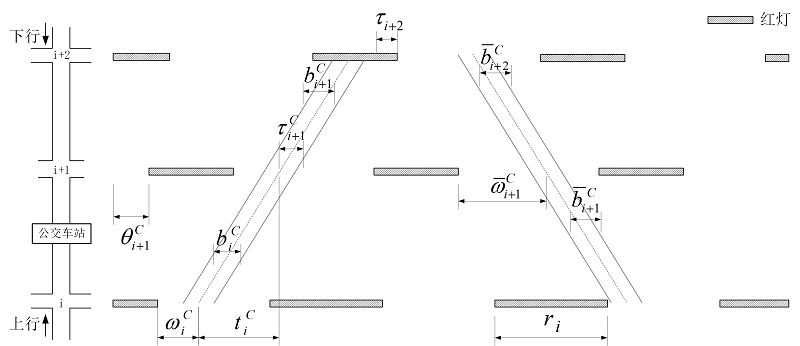
</div>

交叉口偏移量$\tau_{i,k}$，表示当交叉口$k$为干道分割点时，路径$i$在交叉口的偏移量，即当$p_k=1$时，$\tau_{i,k}>0$,否则，$\tau_{i,k}=0$,约束表达为：

$$
\epsilon p_k\leq \mu_{i,k}\leq p_k
$$

In [397]:
for k in range(num):
    for i in range(numr):
        model.add_constraints([nx * p[k] <= u[i, k], u[i, k] <= p[k]])

相同分段子区内部的交叉口绿波带宽相同，约束表达为：

$$\begin{cases}
-M p_{k+1}\leq b_{i,k}-b_{i,k+1}\leq M p_{k+1}\\
-M p_{k}\leq \bar{b}_{i,k}-\bar{b}_{i,k+1}\leq M p_{k}
\end{cases}
$$

In [398]:
def add_split_on_cons(i):
    for k in range(num-1):
        model.add_constraint(-M * p[k + 1] <= b[i, k] - b[i, k + 1])
        model.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k + 1])

        model.add_constraint(-M * p[k + 1] <= y[i, k + 1] - y[i, k])
        model.add_constraint(y[i, k + 1] - y[i, k] <= M * p[k + 1])

        model.add_constraint(o[k] + r[i, k] + w[i, k] + t[0, k] + u[i, k+1]>= 
        o[k + 1] + r[i, k + 1] + w[i, k + 1] + n[i, k + 1] - M * (1 - y[i, k+1]))
        model.add_constraint(o[k] + r[i, k] + w[i, k] + t[0, k] + u[i, k+1]<= 
        o[k + 1] + r[i, k + 1] + w[i, k + 1] + n[i, k + 1] + M * (1 - y[i, k+1]))
def add_split_in_cons(i):
    for k in range(num-1):
        model.add_constraint(-M * p[k] <= b[i, k] - b[i, k + 1])
        model.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k])

        model.add_constraint(-M * p[k] <= y[i, k + 1] - y[i, k])
        model.add_constraint(y[i, k + 1] - y[i, k] <= M * p[k])

        model.add_constraint(o[k] + r[i, k] + w[i, k] + n[i, k]>= 
        o[k + 1]+ r[i, k + 1]+ w[i, k + 1]+ t[1, k]+ u[i, k]- M * (1 - y[i, k]))
        model.add_constraint(o[k] + r[i, k] + w[i, k] + n[i, k]<= 
        o[k + 1]+ r[i, k + 1]+ w[i, k + 1]+ t[1, k]+ u[i, k]+ M * (1 - y[i, k]))

In [399]:
for i in range(numr):
    if ison[i]==0:
        add_split_on_cons(i)
    else:
        add_split_in_cons(i)

### 动态选择路径带宽，阻止无效带宽

传统的multiband带宽可能产生无效带宽，进而浪费交叉口通行资源，具体为：

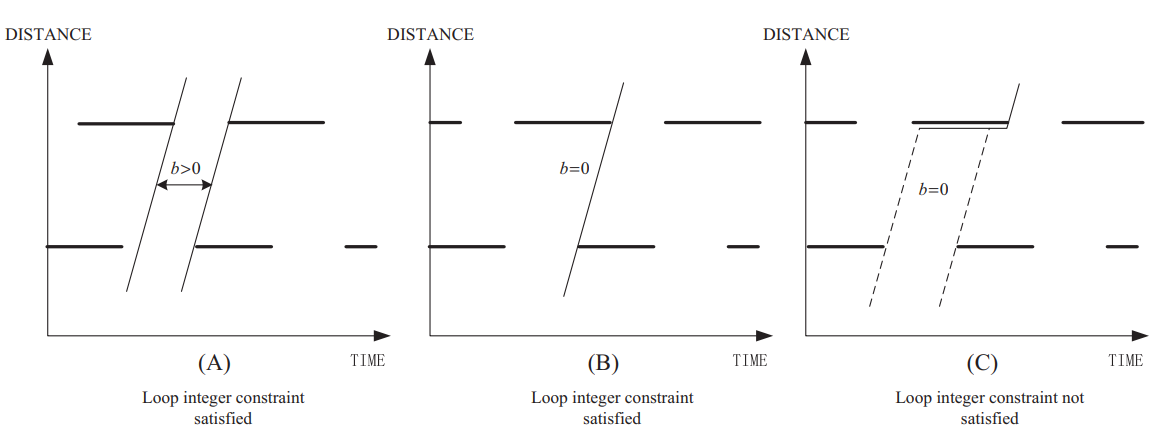

为避免路径产生无效带宽，引入二进制变量$y_{i,k}$,其定义如下：
$$
y_{i,k}=\begin{cases}
1,&\text{如果路径$i$在交叉口$k$能够获得有效非零带宽}\\
0,& \text{其他}
\end{cases}
$$
路径$i$在相同分组内取得相等带宽，进而约束相同分组内交叉口同时取得非零带宽，在不同分组可能无法取得带宽，其约束表达如下：
$$\begin{cases}
-M p_{k+1}\leq y_{i,k}-y_{i,k+1}\leq M p_{k+1}\\
-M p_{k}\leq \bar{y}_{i,k}-\bar{y}_{i,k+1}\leq M p_{k}
\end{cases}
$$
当路径$i$在交叉口$k$取得非零带宽，则应满足如下约束:
$$\begin{cases}
beZ_k-M (1-y_{i,k})\leq b_{i,k}\leq y_{i,k} \\
beZ_k-M (1-\bar{y}_{i,k})\leq \bar{b}_{i,k}\leq \bar{y}_{i,k}
\end{cases}
$$
其含义为，当路径$i$在交叉口$k$能够取得非零带宽,则其带宽应大于基础带宽$be$


In [400]:
for k in range(num):
    for i in range(numr):
        model.add_constraint(be * z[k] - M * (1 - y[i, k]) <= b[i, k])
        model.add_constraint(b[i, k] <= y[i, k])

因引入$y_{i,k}$，当路径$i$在交叉口$k$无法取得有效带宽时，其循环整形约束应不再起作用，循环整形约束可修改为:
$$
\begin{cases}
\theta_k+r_{i,k}+w_{i,k}+t_{k}+\tau_{k+1}\geq \theta_{k+1}+r_{i,k+1}+w_{i,k+1}+n_{i,k+1}-M(1-y_{i,k})\\
\theta_k+r_{i,k}+w_{i,k}+t_{k}+\tau_{k+1}\leq \theta_{k+1}+r_{i,k+1}+w_{i,k+1}+n_{i,k+1}+M(1-y_{i,k})\\ 
\end{cases}
$$

$$
\begin{cases}
\theta_k+\bar{r}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\geq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\tau}_{k}-M(1-y_{i,k})\\
\theta_k+\bar{r}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\leq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\tau}_{k}+M(1-y_{i,k})
\end{cases}
$$
注意到某些情况下，模型可能更偏好某一方向带宽，从而将其他方向的带宽设置为0，为避免这种情况的发生，同时体现模型对上行（下行）方向的偏好，定义约束：
$$
(1-\rho_{k})\sum_i b_{i,k}\geq (1-\rho_{k})\rho_{k} \sum_i \bar{b}_{i,k}
$$
该式能够根据交叉口$k$处上行与下行流量的大小，动态分配绿波带宽


In [401]:
for k in range(num):
    model.add_constraint((1 - rho[k]) * model.sum([b[i, k]*(1-ison[i]) for i in range(numr)])>=\
         (1 - rho[k])* rho[k]* model.sum([b[i, k]*ison[i] for i in range(numr)]))

### 协调周期自动协调

因干道分割可对长干道进行分组，组内实现干道协调，不同组之间互不影响，因此不同分组可采用不同的信号协调周期，其约束表达如下：
$$
\begin{cases}
Z_{min}\leq Z_k\leq Z_{max}\\
-Mp_{k+1}\leq Z_{k+1}-Z_{k}\leq MP_{k+1}
\end{cases}
$$
通过该约束，可实现在不同分段子区之间，可采用不同的信号周期，避免过长的干道采用相同信号周期造成部分交叉口车辆延误过大

In [402]:
for k in range(num-1):
    model.add_constraint(-M * p[k + 1] <= z[k + 1] - z[k])
    model.add_constraint(z[k + 1] - z[k] <= M * p[k + 1])

## 目标函数构建

目标函数包括三部分：
- 最大化每条路径各交叉口的的绿波带宽。
- 最小化分割点停车等待时间。
- 最小化分割次数，并限制分割点流量。
$$
MAX:\sum_{i=1}^{I}\left(\omega_1\sum_{k=1}^{\Omega_i}\left(q_{i}b_{i,k}+\bar{q}_{i}\bar{b}_{i,k} \right)-\omega_2
\sum_{k=1}^{\Omega_i}\left(q_{i}\tau_{i,k}+\bar{q}_{i}\bar{\tau}_{i,k}\right)\right)-\omega_3\sum_{k=1}^{\Omega_i}\left(p_k\left(Q_k+\bar{Q}_k\right)\right)
$$

In [403]:
sum_b = model.sum([qv[i] * b[i, k] for i in range(numr) for k in range(num)])
sum_u = model.sum([qv[i] * u[i, k] for i in range(numr) for k in range(num)])
sum_p = model.sum([p[k] * (vol[0, k] + vol[1, k]) for k in range(num)])

In [404]:
refiner=ConflictRefiner()
res=refiner.refine_conflict(model)
res.display()

conflict(s): 0


In [405]:
model.set_multi_objective("max",[sum_b,sum_u,sum_p],weights=[5,-4,-2])
# model.maximize(sum_b * 5 - sum_u * 4 - sum_p * 1)
sol = model.solve(log_output=True)
print(sol.solve_details)
sol.objective_value

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125

Multi-objective solve log . . .

Index  Priority  Blend          Objective      Nodes  Time (sec.)  DetTime (ticks)

Performing restart 1
    1         0      3   1.3964627696e+04      32345         3.00          1965.03
status  = multi-objective optimal
time    = 3 s.
problem = MILP
gap     = 2.72882e+73%



3665

In [406]:
p = sol.get_value_dict(p)
t = sol.get_value_dict(t)
y = sol.get_value_dict(y)
z = sol.get_value_dict(z)
r = sol.get_value_dict(r)
x = sol.get_value_dict(x)

# 速度波动

### 速度波动变量

In [407]:
mdl=md.Model("variable_phase")

o_list = [(i) for i in range(num)]
o = mdl.continuous_var_dict(o_list, lb=0, ub=1, name="o")

yp_list=[(i,j,k) for i in range(2) for j in range(num) for k in range(lin_num)]
yp=mdl.binary_var_dict(yp_list,name="yp")

nt_list = [(i, j, k) for i in range(2) for j in range(num) for k in range(lin_num)]
nt = mdl.integer_var_dict(nt_list, lb=-1, ub=10, name="nt")

pc_list=[(i,j,k) for i in range(2) for j in range(num) for k in range(lin_num)]
pc=mdl.binary_var_dict(pc_list,name="pc")

C_list=[(i,j,k) for i in range(2) for j in range(num) for k in range(lin_num)]
C=mdl.continuous_var_dict(C_list,lb=0,ub=1,name="C")

w_list = [(i, k) for i in range(numr) for k in range(num)]
w = mdl.continuous_var_dict(w_list, lb=0, ub=1, name="w")

b_list = [(i, k) for i in range(numr) for k in range(num)]
b = mdl.continuous_var_dict(b_list, lb=0, ub=1, name="b")

n_list = [(i, k) for i in range(numr) for k in range(num)]
n = mdl.integer_var_dict(n_list, lb=0, ub=10, name="n")

u_list = [(i, k) for i in range(numr) for k in range(num)]
u = mdl.continuous_var_dict(u_list, lb=0, ub=1, name="u")

### 长干道约束

$$\begin{cases}
b_{i,k}/2\leq w_{i,k}\leq\sum_{l}{\beta_{i,l,k}\phi_{l,k}}-b_{i,k}/2\\
\bar{b}_{i,k}/2\leq \bar{w}_{i,k}\leq \sum_{l}\beta_{i,l,k}\phi_{l,k}-\bar{b}_{i,k}/2
\end{cases}
$$

In [408]:
for i in range(numr):
    for k in range(num):
        mdl.add_constraint(b[i, k] / 2 <= w[i, k])
        mdl.add_constraint(w[i, k]<= sum([phase_get[i, k, l] * phase[k, l] for l in range(numr)])- b[i, k] / 2 )

交叉口偏移量$\tau_{i,k}$，表示当交叉口$k$为干道分割点时，路径$i$在交叉口的偏移量，即当$p_k=1$时，$\tau_{i,k}>0$,否则，$\tau_{i,k}=0$,约束表达为：
$$
\epsilon p_k\leq \mu_{i,k}\leq p_k
$$

In [409]:
for k in range(num):
    for i in range(numr):
        mdl.add_constraints([nx * p[k] <= u[i, k], u[i, k] <= p[k]])

相同分段子区内部的交叉口绿波带宽相同，约束表达为：
$$\begin{cases}
-M p_{k+1}\leq b_{i,k}-b_{i,k+1}\leq M p_{k+1}\\
-M p_{k}\leq \bar{b}_{i,k}-\bar{b}_{i,k+1}\leq M p_{k}
\end{cases}
$$

In [410]:
def add_split_on_cons(i):
    for k in range(num-1):
        mdl.add_constraint(-M * p[k + 1] <= b[i, k] - b[i, k + 1])
        mdl.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k + 1])

        mdl.add_constraint(o[k] + r[i, k] + w[i, k] + t[0, k] + u[i, k+1]>= 
        o[k + 1] + r[i, k + 1] + w[i, k + 1] + n[i, k + 1] - M * (1 - y[i, k+1]))
        mdl.add_constraint(o[k] + r[i, k] + w[i, k] + t[0, k] + u[i, k+1]<= 
        o[k + 1] + r[i, k + 1] + w[i, k + 1] + n[i, k + 1] + M * (1 - y[i, k+1]))
def add_split_in_cons(i):
    for k in range(num-1):
        mdl.add_constraint(-M * p[k] <= b[i, k] - b[i, k + 1])
        mdl.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k])

        mdl.add_constraint(o[k] + r[i, k] + w[i, k] + n[i, k]>= 
        o[k + 1]+ r[i, k + 1]+ w[i, k + 1]+ t[1, k]+ u[i, k]- M * (1 - y[i, k]))
        mdl.add_constraint(o[k] + r[i, k] + w[i, k] + n[i, k]<= 
        o[k + 1]+ r[i, k + 1]+ w[i, k + 1]+ t[1, k]+ u[i, k]+ M * (1 - y[i, k]))

In [411]:
for i in range(numr):
    if ison[i]==0:
        add_split_on_cons(i)
    else:
        add_split_in_cons(i)

当路径$i$在交叉口$k$取得非零带宽，则应满足如下约束:
$$\begin{cases}
beZ_k-M (1-y_{i,k})\leq b_{i,k}\leq y_{i,k} \\
beZ_k-M (1-\bar{y}_{i,k})\leq \bar{b}_{i,k}\leq \bar{y}_{i,k}
\end{cases}
$$
其含义为，当路径$i$在交叉口$k$能够取得非零带宽,则其带宽应大于基础带宽$be$


In [412]:
for k in range(num):
    for i in range(numr):
        mdl.add_constraint(be * z[k] - M * (1 - y[i, k]) <= b[i, k])
        mdl.add_constraint(b[i, k] <= y[i, k])

因引入$y_{i,k}$，当路径$i$在交叉口$k$无法取得有效带宽时，其循环整形约束应不再起作用，循环整形约束可修改为:
$$
\begin{cases}
\theta_k+r_{i,k}+w_{i,k}+t_{k}+\tau_{k+1}\geq \theta_{k+1}+r_{i,k+1}+w_{i,k+1}+n_{i,k+1}-M(1-y_{i,k})\\
\theta_k+r_{i,k}+w_{i,k}+t_{k}+\tau_{k+1}\leq \theta_{k+1}+r_{i,k+1}+w_{i,k+1}+n_{i,k+1}+M(1-y_{i,k})\\ 
\end{cases}
$$

$$
\begin{cases}
\theta_k+\bar{r}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\geq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\tau}_{k}-M(1-y_{i,k})\\
\theta_k+\bar{r}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\leq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\tau}_{k}+M(1-y_{i,k})
\end{cases}
$$
注意到某些情况下，模型可能更偏好某一方向带宽，从而将其他方向的带宽设置为0，为避免这种情况的发生，同时体现模型对上行（下行）方向的偏好，定义约束：
$$
(1-\rho_{k})\sum_i b_{i,k}\geq (1-\rho_{k})\rho_{k} \sum_i \bar{b}_{i,k}
$$
该式能够根据交叉口$k$处上行与下行流量的大小，动态分配绿波带宽


In [413]:
for k in range(num):
    mdl.add_constraint((1 - rho[k]) * mdl.sum([b[i, k]*(1-ison[i]) for i in range(numr)])>=\
         (1 - rho[k])* rho[k]* mdl.sum([b[i, k]*ison[i] for i in range(numr)]))

### 速度波动约束

车辆速度在速度区间$[7.3,14.2]$内呈$X~N(9,1)$的正态分布，分布表示如下：
$$
f(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{(x-9)^2}{2}}
$$
$$
f(x)=\frac{1}{\sigma\sqrt{2*\pi}}e^{-\frac{x-\mu}{2\sigma^2}}
$$

In [414]:
def getprop(linspace1,linspace2,mu,sigma):
    t1=stats.norm(mu,sigma).cdf(linspace1)
    t2=stats.norm(mu,sigma).cdf(linspace2)
    return t2-t1

In [415]:
mu=9
sigma=np.sqrt(2)
print(linspace)
ProDistribution=getprop(linspace-0.25,linspace+0.25,mu,sigma)
np.around(ProDistribution,2)

[ 8  9 10 11]


array([0.11, 0.14, 0.11, 0.05])

$i$表示路径，$j$表示相位，$k$表示交叉口
- $A_k$ ：表示上行带宽所处红灯结束（绿灯开始时间）点位

- $B_k$: 表示上行带宽所处绿灯结束（红灯开始时间）点位

- $A_{k}^{\prime}$:上行带宽与交叉口相位的左侧交点

- $B_{k}^{\prime}$:上行带宽与交叉口相位的右侧交点

- $\bar{A}_{k}$：表示下行带宽所处红灯结束（绿灯开始时间）点位

-  $\bar{B}_{k}$: 表示下行带宽所处绿灯结束（红灯开始时间）点位

- $\bar{A}_{k}^{\prime}$:下行带宽与交叉口相位的左侧交点

- $\bar{B}_{k}^{\prime}$:下行带宽与交叉口相位的右侧交点
$$\begin{cases}
A_{k,v}=\theta_k+rs_k\\
B_{k,v}=\theta_k+r_k+gs_k\\
A_{k,v}^{\prime}=max\{A_{k-1,v}^{\prime}+d_{k-1}/v*z_k-M*(1-p_k),A_{k,v}+\tau_k+n_{k,v}\}\\
B_{k,v}^{\prime}=min\{B_{k-1,v}^{\prime}+d_{k-1}/v*z_k+M*(1-p_k),B_{k,v}+n_{k,v}\}\\
\bar{A}_{k}=\theta_k+\bar{rs}_k+\Delta_k\\
\bar{B}_{k}=\theta_k+\bar{rs}_k+\bar{gs}_k+\Delta_k\\
\bar{A}_{k,v}^{\prime}=max\{\bar{A}_{k+1,v}^{\prime}+d_{k}/v*z_k-M*(1-p_k),\bar{A}_{k,v}+\bar{\tau}_k+\bar{n}_{k,v}\}\\
\bar{B}_{k,v}^{\prime}=min\{\bar{B}_{k+1,v}^{\prime}+d_{k}/v*z_k+M*(1-p_k),\bar{B}_{k,v}+\bar{n}_{k,v}\}
\end{cases}
$$

In [416]:
def add_var_on_cons(A, B, o, r, g, t, n, k, end, yp, px, p,pc,C,onbound):
    if k>=end:
        mdl.add_constraint(pc[k-1]==yp[k-1])
        return onbound
    else:
        if p[k]==1:
            A1=o[k]+r[k]+n[k]+px[k]
            B1=o[k]+r[k]+n[k]+g[k]
        else:
            A1=mdl.max(A+t[k-1],o[k]+r[k]+n[k]+px[k])
            B1=mdl.min(B+t[k-1], o[k]+r[k]+n[k]+g[k])
        # A1=model.max(A+t[k-1]-M*p[k],o[k]+r[k]+n[k]+px[k])
        # B1=model.min(B+t[k-1]+M*p[k], o[k]+r[k]+n[k]+g[k])

        mdl.add_constraints([C[k]<=(B1-A1),C[k]>=(B1-A1)-M*(1-pc[k]),C[k]>=-M*pc[k],C[k]<=M*pc[k]])

        mdl.add_constraints([be*z[k]-M*(1-yp[k]) <= B1-A1, B1-A1 <= yp[k]+M*(1-yp[k])])
        mdl.add_constraints([p[k]>=pc[k-1],yp[k-1]>=pc[k-1],pc[k-1]>=p[k]+yp[k-1]-1])
        onbound.append([A1,B1,B1-A1])
        return add_var_on_cons(A1, B1, o, r, g, t, n, k+1, end, yp, px, p,pc,C,onbound)

def add_var_in_cons(A, B, o, r, g, t, n, k, end, yp, px, p,pc,C,inbound):
    if k<=end:
        mdl.add_constraint(pc[k+1]==yp[k+1])
        return inbound
    else:
        if p[k]==1:
            A1=o[k]+r[k]+n[k]+px[k]
            B1=o[k]+r[k]+n[k]+g[k]
        else:
            A1=mdl.max(A+t[k],o[k]+r[k]+n[k]+px[k])
            B1=mdl.min(B+t[k], o[k]+r[k]+n[k]+g[k])
        # A=mdl.max(A+t[k]-M*p[k], o[k]+r[k]+n[k]+px[k])
        # B=mdl.min(B+t[k]+M*p[k], o[k]+r[k]+g[k]+n[k])
        
        mdl.add_constraints([be*z[k]-M*(1-yp[k]) <= B1-A1, B1-A1 <= g[k]+M*(1-yp[k])])
        mdl.add_constraints([p[k]>=pc[k+1],yp[k+1]>=pc[k+1],p[k]+yp[k+1]-1<=pc[k+1]])

        mdl.add_constraints([C[k]<=(B1-A1),C[k]>=(B1-A1)-M*(1-pc[k]),C[k]>=-M*pc[k],C[k]<=M*pc[k]])
        inbound.append([A1,B1,B1-A1])
        return add_var_in_cons(A1, B1, o, r, g, t, n, k-1, end, yp, px, p,pc,C,inbound)

In [417]:
sum_on=0
sum_in=0
onbound_x=[]
inbound_x=[]
for i,v in enumerate(linspace):
    A_on_0=o[0]+min(get_grf(x,phase,2,0,numr),get_grf(x,phase,3,0,numr))
    B_on_0=A_on_0+sg[0,0]
    mdl.add_constraints([C[0,0,i]<=(B_on_0-A_on_0),C[0,0,i]>=(B_on_0-A_on_0)-M*(1-pc[0,0,i]),
    C[0,0,i]>=-M*pc[0,0,i],C[0,0,i]<=M*pc[0,0,i]])

    onb=add_var_on_cons(
        A=A_on_0,
        B=B_on_0,
        o=o,
        r=[min(get_grf(x,phase,2,k,numr),get_grf(x,phase,3,k,numr)) for k in range(num)],
        g=sg[0],
        t=np.array([d[j]/v*z[j] for j in range(num-1)]),
        n=np.array([nt[0,j,i] for j in range(num)]),
        k=1,
        end=num,
        yp=np.array([yp[0,j,i] for j in range(num)]),
        px=px[0],
        p=p,
        pc=np.array([pc[0,j,i] for j in range(num)]),
        C=[C[0,k,i] for k in range(num)],
        onbound=[[A_on_0,B_on_0,o[0]+sg[0,0]]]
    )
    sum_on+=mdl.sum([C[0,k,i]*vol[0,k] for k in range(num)])*ProDistribution[i]
    onbound_x.append(onb)

    A_in_0=o[num-1]+min(get_grf(x,phase,3,num-1,numr),get_grf(x,phase,4,num-1,numr))
    B_in_0=A_in_0+sg[1,num-1]
    mdl.add_constraints([C[1,num-1,i]<=(B_in_0-A_in_0),C[1,num-1,i]>=(B_in_0-A_in_0)-M*(1-pc[1,num-1,i]),
    C[1,num-1,i]>=-M*pc[1,num-1,i],C[1,num-1,i]<=M*pc[1,num-1,i]])
    
    inb=add_var_in_cons(
        A=A_in_0,
        B=B_in_0,
        o=o,
        r=[min(get_grf(x,phase,3,k,numr),get_grf(x,phase,4,k,numr)) for k in range(num)],
        g=sg[1],
        t=np.array([d[j]/v*z[j] for j in range(num-1)]),
        n=np.array([nt[1,j,i] for j in range(num)]),
        k=num-2,
        end=-1,
        yp=np.array([yp[1,j,i] for j in range(num)]),
        px=px[1],
        p=p,
        pc=np.array([pc[1,j,i] for j in range(num)]),
        C=[C[1,k,i] for k in range(num)],
        inbound=[[A_in_0,B_in_0,o[0]+sg[1,num-1]]]
    )
    # sum_in+=mdl.sum([C[1,k,i]*vol[1,k] for k in range(num)])*ProDistribution[i]
    # inbound_x.append(inb)

为避免某些速度下无法取得有效带宽，进而影响其他速度下的带宽，可尽量
$$
\eta_{k,v}=\begin{cases}
1,&\text{如果速度$v$在交叉口$k$下能够获得有效带宽}\\
0,& \text{其他}
\end{cases}
$$
$$
\begin{cases}
be*z_k-M(1-\eta_{k,v})\leq B^{\prime}_{k,v} -A ^{\prime}_{k,v} \leq \eta_{k,v}+M*(1-\eta_{k,v})\\
be*z_k-M(1-\bar{\eta}_{k,v})\leq B^{\prime}_{k,v} -A ^{\prime}_{k,v} \leq \bar{\eta}_{k,v}+M*(1-\bar{\eta}_{k,v})
\end{cases}
$$

为了保证带宽式中为正，应确保点$B^{\prime}_k(\bar{B}^{\prime}_k)$始终处于点$A^{\prime}_k(\bar{A}^{\prime}_k)$的右侧，约束表示为：
$$
\begin{cases}
-M*(1-\eta_{k,v})\leq B^{\prime}_{k,v}-A^{\prime}_{k,v}\leq g_{k}+M*(1-\eta_{k,v})\\
-M*(1-\bar{\eta}_{k,v} )\leq\bar{B}^{\prime}_{k,v}-\bar{A}^{\prime}_{k,v} \leq \bar{g}_k+M*(1-\bar{\eta}_{k,v})
\end{cases}
$$

$$
\begin{cases}
b_{k,v}=B_{k,v}^{\prime}-A_{k,v}^{\prime},& k=1,2,...,n,&v \in \Omega_v \\
\bar{b}_{k,v}=\bar{B}_{k,v}^{\prime}-\bar{A}_{k,v}^{\prime},& k=0,1,...,n-1,&v \in \Omega_v
\end{cases}
$$

$$
\begin{cases}
-Mp_{k+1}\leq\eta_{k,v}-\eta_{k+1,v}\leq Mp_{k+1}\\
-Mp_{k}\leq\bar{\eta}_{k,v}-\bar{\eta}_{k+1,v}\leq Mp_{k}
\end{cases}
$$

In [418]:
for k in range(num-1):
    for v in range(lin_num):
        mdl.add_constraints([-M*p[k+1] <= yp[0, k, v]-yp[0, k+1, v], yp[0, k, v]-yp[0, k+1, v] <= M*p[k+1]])
        mdl.add_constraints([-M*p[k] <= yp[1, k, v]-yp[1, k+1, v], yp[1, k, v]-yp[1, k+1, v] <= M*p[k]])

## 速度波动目标构建

速度波动目标函数为
$$
MAX: \sum_{v\in\Omega}\left(\omega_1\sum_{k=1}^{I}Q_kp_k\eta_{k,v}(B^{\prime}_{k,v}-A^{\prime}_{k,v})+\bar{Q}_kp_k\bar{\eta}_{k,v}(\bar{B}^{\prime}_{k,v}-\bar{A}^{\prime}_{k,v})\right)
$$

In [419]:
sum_b = mdl.sum([qv[i] * b[i, k] for i in range(numr) for k in range(num)])
sum_u = mdl.sum([qv[i] * u[i, k] for i in range(numr) for k in range(num)])
sum_v=sum_in+sum_on

In [420]:
refiner=ConflictRefiner()
res=refiner.refine_conflict(mdl)
res.display()


KeyboardInterrupt
conflict(s): 356
  - status: Possible_member, Variable Upper Bound: o_1 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_2 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_3 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_4 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_5 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_6 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_7 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_8 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_9 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_10 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_11 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_12 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_13 <= 1.0
  - status: Possible_member, Variable Upper Bound: o_14 <= 1.0
  - status: Possible_member, Variable Upper Bound: yp_0_0_0 <= 1
  - status: Possible_membe

In [ ]:
mdl.set_multi_objective("max",[sum_b,sum_u,sum_v],weights=[5,-4,1])
# mdl.set_multi_objective("max",[sum_b,sum_u],weights=[5,-4])
sol = mdl.solve(log_output=True)
print(sol.solve_details)
sol.objective_value

In [ ]:
o = sol.get_value_dict(o)
w = sol.get_value_dict(w)
n = sol.get_value_dict(n)
u = sol.get_value_dict(u)
b = sol.get_value_dict(b)
yp = sol.get_value_dict(yp)
pc=sol.get_value_dict(pc)
nt=sol.get_value_dict(nt)
C=sol.get_value_dict(C)

In [ ]:
Df=[[i for i in range(1,num+1)]]
Df+=[[d[i] for i in range(num-1)] + [np.nan]]
Df+=[[b[i,k] for k in range(num)] for i in range(numr)]
Df+=[[o[k] for k in range(num)]]
Df+=[[p[k] for k in range(num)]]
Df+=[[t[i,k] for k in range(num-1)]+[np.nan] for i in range(2)]
Df+=[[y[i,k] for k in range(num)] for i in range(numr)]
Df+=[[1/z[k] for k in range(num)]]
Df+=[[u[i,k] for k in range(num)] for i in range(numr)]
Df+=[[yp[i,k,j] for k in range(num)] for j in range(lin_num) for i in range(2)]
Df+=[[r[i,k] for k in range(num)] for i in range(numr)]
Df=np.array(Df)
Df=Df.T
Df=pd.DataFrame(Df)
cols=["cross_number"]
cols+=["distance"]
cols+=["b"+str(i) for i in range(1,numr+1)]
cols+=["offset","p"]
cols+=["t"+str(i) for i in range(1,3)]
cols+=["y"+str(i) for i in range(1,numr+1)]
cols+=["z"]
cols+=["u"+str(i) for i in range(1,numr+1)]
cols+=["yp_on_"+str(i) for i in range(1,lin_num+1)]
cols+=["yp_in_"+str(i) for i in range(1,lin_num+1)]
cols+=["r"+str(i) for i in range(1,numr+1)]
Df.columns=cols
Df["offset"] = Df.offset * Df.z
Df["t1"] = Df.t1 * Df.z
Df["t2"] = Df.t2 * Df.z
Df["b1"] = Df.b1 * Df.z
Df["b2"] = Df.b2 * Df.z
Df["b3"] = Df.b3 * Df.z
Df["b4"] = Df.b4 * Df.z
Df["b5"] = Df.b5 * Df.z
Df["b6"] = Df.b6 * Df.z
Df["r1"] = Df.r1 * Df.z
Df["r2"] = Df.r2 * Df.z
Df["r3"] = Df.r3 * Df.z
Df["r4"] = Df.r4 * Df.z
Df["r5"] = Df.r5 * Df.z
Df["r6"] = Df.r6 * Df.z
Df=Df.round(2)

In [ ]:
x_list = np.array(
    [x[l, m, k] for l in range(numr) for m in range(numr) for k in range(num)], dtype=int
).reshape(6, 6, num)

In [ ]:
Df2 = Df.copy()
Df2["w1"] = [w[0, k] for k in range(num)]
Df2["w2"] = [w[1, k] for k in range(num)]
Df2["w3"] = [w[2, k] for k in range(num)]
Df2["w4"] = [w[3, k] for k in range(num)]
Df2["w5"] = [w[4, k] for k in range(num)]
Df2["w6"] = [w[5, k] for k in range(num)]
Df2["u1"] = np.array([u[0, k] for k in range(num)]) * Df.z
Df2["u2"] = np.array([u[1, k] for k in range(num)]) * Df.z
Df2["u3"] = np.array([u[2, k] for k in range(num)]) * Df.z
Df2["u4"] = np.array([u[3, k] for k in range(num)]) * Df.z
Df2["u5"] = np.array([u[4, k] for k in range(num)]) * Df.z
Df2["u6"] = np.array([u[5, k] for k in range(num)]) * Df.z
Df2["car_t1"] = Df2.offset + Df2.r1 + Df2.w1 * Df2.z - Df2.b1 / 2
Df2["car_t2"] = Df2.offset + Df2.r2 + Df2.w2 * Df2.z - Df2.b2 / 2
Df2["car_t3"] = Df2.offset + Df2.r3 + Df2.w3 * Df2.z - Df2.b3 / 2
Df2["car_t4"] = Df2.offset + Df2.r4 + Df2.w4 * Df2.z - Df2.b4 / 2
Df2["car_t5"] = Df2.offset + Df2.r5 + Df2.w5 * Df2.z - Df2.b5 / 2
Df2["car_t6"] = Df2.offset + Df2.r6 + Df2.w6 * Df2.z - Df2.b6 / 2
Df3=Df2.copy()

In [ ]:
Df2

# 六、可视化

In [ ]:
Df2=Df3.copy()

In [ ]:
green_time = np.array([phase[i] * Df2.z[i] for i in range(num)])

In [ ]:
def data_formater(data, last_data, cross_num):
    while data < last_data:
        data += Df.z[cross_num]
    return data


def onbound(b, car_t, t, dis, distance):
    zip_x = [
        car_t,
        car_t + b,
        car_t + t + b,
        car_t + t,
    ]
    zip_y = [dis, dis, dis + distance, dis + distance]
    return zip_x, zip_y


def inbound(b, car_t, t, dis, distance):
    zip_x = [
        car_t + t,
        car_t + t + b,
        car_t + b,
        car_t,
    ]
    zip_y = [dis - distance, dis - distance, dis, dis]
    return zip_x, zip_y

In [ ]:
# color = ["red", "darkgray", "cyan", "g", "slateblue", "yellow"]
color = ["white", "white", "white", "white", "white", "white"]
fig1 = plt.figure(figsize=(20, 20), dpi=300)
ax1 = fig1.add_subplot()
legends = ["1->15", "1->6", "8->15", "15->2", "14->9", "7->1"]
legends_arrow = [r"$\rightleftarrows$"]
Df2.car_t1 += Df2.z
Df2.car_t2 += Df2.z * 2
Df2.car_t3 += Df2.z * 3
for i in range(1, num):
    Df2.loc[i, "car_t1"] = data_formater(Df2.car_t1[i], Df2.car_t1[i - 1], i)
    Df2.loc[i, "car_t2"] = data_formater(Df2.car_t2[i], Df2.car_t2[i - 1], i)
    Df2.loc[i, "car_t3"] = data_formater(Df2.car_t3[i], Df2.car_t3[i - 1], i)

Df2.car_t5 += Df2.z
Df2.car_t6 += Df2.z * 2
for i in range(num - 1, 0, -1):
    Df2.loc[i - 1, "car_t4"] = data_formater(Df2.car_t4[i - 1], Df2.car_t4[i], i - 1)
    Df2.loc[i - 1, "car_t5"] = data_formater(Df2.car_t5[i - 1], Df2.car_t5[i], i - 1)
    Df2.loc[i - 1, "car_t6"] = data_formater(Df2.car_t6[i - 1], Df2.car_t6[i], i - 1)

max_width = (
    max(Df2[["car_t1", "car_t2", "car_t3", "car_t4", "car_t5", "car_t6"]].max())
    + Df2.z.max()
)
max_hight = sum(Df.distance[0 : num - 1]) + 100
legendc = dict()
for i in range(0, num):
    x_list_i = x_list[:, :, i].sum(axis=0)
    x_list_i_sort = x_list_i.argsort()
    offset_r = Df2.offset[i] - Df2.z[i]
    sum_dis = sum(Df2.distance[0:i])
    while offset_r < max_width:
        for j in x_list_i_sort:
            if green_time[i, j] == 0:
                continue
            else:
                if phase_get[0,i,j]==1:
                    legendc["{}".format(j)] = ax1.add_patch(
                        plt.Rectangle(
                            (offset_r, sum_dis),
                            green_time[i, j],
                            20,
                            color="green",
                        )
                    )
                else:
                    legendc["{}".format(j)] = ax1.add_patch(
                        plt.Rectangle(
                            (offset_r, sum_dis),
                            green_time[i, j],
                            20,
                            color=color[j],
                        )
                    )
                offset_r += green_time[i, j]
    ax1.text(10, sum(Df2.distance[0:i]) + 25, str(i + 1), fontsize=12)
# ax1.legend(
#     handles=[
#         legendc["0"],
#         legendc["1"],
#         legendc["2"],
#         legendc["3"],
#         legendc["4"],
#         legendc["5"],
#     ],
#     labels=["      ", "      ", "      ", "      ", "      ", "      "],
#     fontsize=12,
#     loc="center right",
# )
plt.plot([0, 0], [0, max_hight])

ax2 = ax1.twinx()
if Df2.car_t2[0] - Df2.car_t1[0] <= Df2.z[0] / 2:
    Df2.loc[0, "car_t2"] += Df2.z[0]

if Df2.car_t3[0] - Df2.car_t2[0] <= Df2.z[0] / 2:
    Df2.loc[0, "car_t3"] += Df2.z[0]


for i in range(0, num):
    dis = sum(Df2.distance[0:i])
    if Df2.b1[i] == 0:
        continue
    else:
        zip_x, zip_y = onbound(
            Df2.b1[i], Df2.car_t1[i], Df2.t1[i], dis, Df2.distance[i]
        )
        onbound1 = ax1.add_patch(pch.Polygon(xy=list(zip(zip_x, zip_y)), fill=False,color='g'))

# for i in range(0, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b2[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = onbound(
#             Df2.b2[i], Df2.car_t2[i], Df2.t1[i], dis, Df2.distance[i]
#         )
#         onbound2 = ax1.add_patch(
#             pch.Polygon(
#                 xy=list(zip(zip_x, zip_y)), fill=False,color='r'
#             )
#         )

# for i in range(0, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b3[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = onbound(
#             Df2.b3[i], Df2.car_t3[i], Df2.t1[i], dis, Df2.distance[i]
#         )
#         onbound3 = ax1.add_patch(
#             pch.Polygon(
#                 xy=list(zip(zip_x, zip_y)),
#                 fill=False,
#                 color='y'
#             )
#         )
# for i in range(1, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b4[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = inbound(
#             Df2.b4[i], Df2.car_t4[i], Df2.t2[i - 1], dis, Df2.distance[i - 1]
#         )
#         inbound1 = ax1.add_patch(
#             pch.Polygon(
#                 xy=list(zip(zip_x, zip_y)),
#                 fill=False,
#                 color='b'
#             )
#         )

# for i in range(1, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b5[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = inbound(
#             Df2.b5[i], Df2.car_t5[i], Df2.t2[i - 1], dis, Df2.distance[i - 1]
#         )
#         inbound2 = ax1.add_patch(
#             pch.Polygon(
#                 xy=list(zip(zip_x, zip_y)),
#                 fill=False,
#                 color='purple'
#             )
#         )

# for i in range(1, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b6[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = inbound(
#             Df2.b6[i], Df2.car_t6[i], Df2.t2[i - 1], dis, Df2.distance[i - 1]
#         )
#         inbound3 = ax1.add_patch(
#             pch.Polygon(
#                 xy=list(zip(zip_x, zip_y)),
#                 fill=False,
#             )
#         )
plt.xlim(
    [
        0,
        max_width,
    ]
)
plt.ylim(0, sum(Df.distance[0 : num - 1]) + 100)
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
# ax2.legend(
#     handles=[onbound1, onbound2, onbound3, inbound1, inbound2, inbound3],
#     labels=["path{}:".format(i) + legends[i - 1] for i in range(1, 7)],
#     fontsize=12,
#     loc="center right",
# )
# fig1.savefig(
#     r"./时距图", bbox_inches="tight"
# )

## 速度波动绘图

In [ ]:
onbound3=[]
for i in range(lin_num):
    tmp=[]
    for k in range(num):
        tmp.append([sol.get_value(onbound_x[i][k][0]),sol.get_value(onbound_x[i][k][1]),sol.get_value(onbound_x[i][k][2])])
    onbound3.append(tmp)

In [ ]:
bod=pd.DataFrame(onbound3[0])
bod.columns=["A","B","B-A"]
bod["C"]=[C[0,k,0] for k in range(num)]
bod["pc"]=[pc[0,i,0] for i in range(num)]
bod["p"]=[p[i] for i in range(num)]
bod["yp"]=[yp[0,i,0] for  i in range(num)]

In [ ]:
bod.round(2)

In [ ]:
from IPython.display import HTML

HTML(
    """<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>"""
)